# IFS Operational Data Availability Check

## Overview
This notebook checks the availability of meteorological parameters from ECMWF IFS operational forecasts via MARS (Meteorological Archival and Retrieval System). It verifies data availability for specified date ranges **without downloading the actual data**.

## Purpose
- Check availability of weather parameters from IFS operational dataset
- Verify data exists for all required dates and variables
- Validate MARS request configurations
- Test data access before running full download jobs

## Data Sources
- **IFS Operational**: ECMWF's operational Integrated Forecasting System
- **MARS API**: ECMWF's data archival system
- **Geographic Coverage**: Europe (70.5/-23.5/29.5/62.5)

---

In [ ]:
"""
IFS Operational Data Availability Check

This notebook checks MARS availability for IFS operational forecasts
without downloading the data. It uses MARS list requests to verify
that all required parameters are available for the specified date range.
"""

import sys
import os
import datetime
import pandas as pd
from pathlib import Path

# Add Scripts directory to Python path for local module imports
# This handles both interactive and batch execution
current_dir = Path.cwd()
scripts_dir = current_dir / 'Scripts'

# Add both Scripts and parent directory to path
for path_to_add in [scripts_dir, current_dir]:
    if path_to_add.exists() and str(path_to_add) not in sys.path:
        sys.path.insert(0, str(path_to_add))

# Import local modules
from c_directories import c_directories
from c_api_request import c_api_request

print("Modules imported successfully!")
print(f"Working directory: {current_dir}")

Modules imported successfully!


## Parameters

These parameters can be overridden when running via papermill in a SLURM job.

In [ ]:
# Parameters cell - tagged for papermill
# These values can be overridden when running via SLURM job
date_i = "20241111"  # Start date (YYYYMMDD)
date_f = "20241114"  # End date (YYYYMMDD)

## Configuration

Set your date range and initialize the directory structure.

In [ ]:
# Initialize directory structure
# date_i and date_f are defined in the Parameters cell above
# Ensure dates are strings (papermill may pass them as integers)
date_i = str(date_i)
date_f = str(date_f)

dirs = c_directories("ifs", "leonardo")
check_dir = dirs.nwp_check
check_dir.mkdir(parents=True, exist_ok=True)

print(f"Checking IFS data availability from {date_i} to {date_f}")
print(f"Results will be saved to: {check_dir / 'ifs_availability.csv'}")

Checking IFS data availability from 20241111 to 20241114
Results will be saved to: /leonardo_scratch/large/userexternal/lmonaco0/DE374_lot2/ifs/check/ifs_availability.csv


## MARS Request Builder

Create a function to build MARS requests for checking data availability. We'll use the `list` retrieve method which returns metadata without downloading the actual data files.

In [3]:
def build_ifs_check_request(date: str, param: str) -> dict:
    """
    Build a MARS request to check IFS operational data availability.
    
    Uses 'list' retrieve method to check availability without downloading.
    
    Args:
        date: Date in YYYYMMDD format
        param: ECMWF parameter code (shortName or param number)
        
    Returns:
        dict: MARS request dictionary for availability check
    """
    return {
        "class": "od",           # Operational archive
        "stream": "oper",        # Operational stream
        "expver": "1",           # Experiment version
        "type": "fc",            # Forecast
        "levtype": "sfc",        # Surface level
        "date": date,            # Forecast date
        "time": "00:00:00",      # Base time (00 UTC)
        "step": "0/to/24/by/1",  # Forecast steps 0-24 hours
        "param": param,          # Parameter to check
        "area": "70.5/-23.5/29.5/62.5",  # Europe bounding box
    }

# Test the function
test_request = build_ifs_check_request("20251201", "2t")
print("Example MARS request:")
for key, value in test_request.items():
    print(f"  {key}: {value}")

Example MARS request:
  class: od
  stream: oper
  expver: 1
  type: fc
  levtype: sfc
  date: 20251201
  time: 00:00:00
  step: 0/to/24/by/1
  param: 2t
  area: 70.5/-23.5/29.5/62.5


## Define Required Variables

Specify the IFS operational variables you need. These are the ECMWF parameter codes:
- **167.128**: 2m temperature
- **168.128**: 2m dewpoint temperature  
- **165.128**: 10m U wind component
- **166.128**: 10m V wind component
- **228.128**: Total precipitation
- **228246/228247**: 100m wind components (U/V)
- **39-42**: Volumetric soil moisture (layers 1-4)
- **43**: Soil type
- **172**: Land-sea mask
- **26**: Lake cover
- **129**: Geopotential (surface orography)

You can modify this list based on your specific requirements.

In [4]:
# Define the IFS operational parameters to check
# Using ECMWF parameter codes (table.param format)
parameters = {
    "167.128": "2m temperature",
    "168.128": "2m dewpoint temperature",
    "165.128": "10m U wind component",
    "166.128": "10m V wind component",
    "228.128": "Total precipitation",
    "228246": "100m U wind component",
    "228247": "100m V wind component",
    "39": "Volumetric soil moisture (layer 1)",
    "40": "Volumetric soil moisture (layer 2)",
    "41": "Volumetric soil moisture (layer 3)",
    "42": "Volumetric soil moisture (layer 4)",
    "43": "Soil type",
    "172": "Land-sea mask",
    "26": "Lake cover",
    "129": "Geopotential (surface orography)",
}

print(f"Checking availability for {len(parameters)} variables:")
for code, description in parameters.items():
    print(f"  {code:10s} - {description}")

Checking availability for 15 variables:
  167.128    - 2m temperature
  168.128    - 2m dewpoint temperature
  165.128    - 10m U wind component
  166.128    - 10m V wind component
  228.128    - Total precipitation
  228246     - 100m U wind component
  228247     - 100m V wind component
  39         - Volumetric soil moisture (layer 1)
  40         - Volumetric soil moisture (layer 2)
  41         - Volumetric soil moisture (layer 3)
  42         - Volumetric soil moisture (layer 4)
  43         - Soil type
  172        - Land-sea mask
  26         - Lake cover
  129        - Geopotential (surface orography)


## Availability Check Function

Create a function to check data availability using earthkit-data's MARS interface. The function will attempt to list the data without downloading it.

In [5]:
import earthkit.data as ek

def check_mars_availability(request: dict) -> tuple[bool, str, dict]:
    """
    Check if data is available in MARS without downloading.
    
    Args:
        request: MARS request dictionary
        
    Returns:
        tuple: (available, message, metadata_dict)
            - available: True if data exists
            - message: Status message
            - metadata_dict: Dictionary with available steps/times if successful
    """
    try:
        # Use earthkit-data to query MARS
        # The "mars" source will execute a MARS request
        # We request minimal data to check availability
        result = ek.from_source("mars", **request)
        
        # If we get here without exception, data is available
        num_messages = len(result)
        
        # Extract metadata about available data
        metadata = {
            "num_messages": num_messages,
            "available": True
        }
        
        return True, f"Available ({num_messages} GRIB messages)", metadata
        
    except Exception as e:
        error_msg = str(e)
        
        # Check for common error patterns
        if "No data is available" in error_msg or "no fields found" in error_msg.lower():
            return False, "No data available", {"available": False}
        elif "authentication" in error_msg.lower() or "credentials" in error_msg.lower():
            return False, f"Authentication error: {error_msg[:100]}", {"available": False}
        else:
            return False, f"Error: {error_msg[:100]}", {"available": False}

print("Availability check function defined.")

Availability check function defined.


## Run Availability Check

Now we'll systematically check each parameter for each date in the range.

In [6]:
# Initialize results list
results = []

# Convert dates to datetime for iteration
start_date = datetime.datetime.strptime(date_i, "%Y%m%d")
end_date = datetime.datetime.strptime(date_f, "%Y%m%d")
current_date = start_date

# Iterate through each date
total_checks = (end_date - start_date).days + 1
current_check = 0

print(f"Starting availability check...")
print(f"Date range: {date_i} to {date_f} ({total_checks} days)")
print(f"Variables: {len(parameters)} parameters")
print(f"Total checks: {total_checks * len(parameters)}")
print("-" * 80)

while current_date <= end_date:
    date_str = current_date.strftime("%Y%m%d")
    
    # Check each parameter
    for param_code, param_desc in parameters.items():
        current_check += 1
        
        # Build MARS request
        request = build_ifs_check_request(date_str, param_code)
        
        # Check availability
        print(f"[{current_check}/{total_checks * len(parameters)}] Checking {date_str} - {param_code:6s} ({param_desc})...", end=" ")
        
        available, message, metadata = check_mars_availability(request)
        
        print(message)
        
        # Store result
        results.append({
            "date": date_str,
            "parameter_code": param_code,
            "parameter_name": param_desc,
            "available": available,
            "status": message,
            "num_messages": metadata.get("num_messages", 0)
        })
    
    # Move to next day
    current_date += datetime.timedelta(days=1)

print("-" * 80)
print(f"Availability check completed!")

Starting availability check...
Date range: 20241111 to 20241114 (4 days)
Variables: 15 parameters
Total checks: 60
--------------------------------------------------------------------------------
[1/60] Checking 20241111 - 167.128 (2m temperature)... 2025-12-22 15:20:20 ECMWF API python library 1.6.5
2025-12-22 15:20:20 ECMWF API at https://api.ecmwf.int/v1
2025-12-22 15:20:20 Welcome Luca Monaco
2025-12-22 15:20:20 In case of problems, please check https://confluence.ecmwf.int/display/WEBAPI/Web+API+FAQ or contact servicedesk@ecmwf.int
2025-12-22 15:20:21 Request submitted
2025-12-22 15:20:21 Request id: 694953a5b8d820ad991cc6c3
2025-12-22 15:20:21 Request is submitted
2025-12-22 15:20:22 Request is queued
2025-12-22 15:21:56 Request is active
2025-12-22 15:22:06 Calling 'nice mars /tmp/20251222-1420/42/tmp-_mars-CT6PyR-51776d8048ba6a2104bbf6de57e30046.req'
2025-12-22 15:22:06 Forcing MIR_CACHE_PATH=/data/ec_coeff
2025-12-22 15:22:06 mars - WARN -
2025-12-22 15:22:06 mars - WARN -
202

## Analyze Results

Create a summary dataframe and analyze the availability results.

In [7]:
# Create DataFrame from results
df = pd.DataFrame(results)

# Calculate summary statistics
total_checks = len(df)
available_count = df['available'].sum()
missing_count = total_checks - available_count
availability_rate = (available_count / total_checks * 100) if total_checks > 0 else 0

print("=" * 80)
print("AVAILABILITY SUMMARY")
print("=" * 80)
print(f"Total checks performed: {total_checks}")
print(f"Available: {available_count} ({availability_rate:.1f}%)")
print(f"Missing: {missing_count} ({100-availability_rate:.1f}%)")
print("-" * 80)

# Show availability by parameter
print("\nAvailability by Parameter:")
param_summary = df.groupby('parameter_code').agg({
    'available': ['sum', 'count']
}).round(2)
param_summary.columns = ['Available', 'Total']
param_summary['Rate (%)'] = (param_summary['Available'] / param_summary['Total'] * 100).round(1)
print(param_summary.to_string())

# Show missing data if any
if missing_count > 0:
    print("\n" + "=" * 80)
    print("MISSING DATA DETAILS")
    print("=" * 80)
    missing_df = df[~df['available']][['date', 'parameter_code', 'parameter_name', 'status']]
    print(missing_df.to_string(index=False))
else:
    print("\n✓ All required data is available!")

# Display first few rows of results
print("\n" + "=" * 80)
print("SAMPLE RESULTS (first 10 rows)")
print("=" * 80)
print(df.head(10).to_string(index=False))

AVAILABILITY SUMMARY
Total checks performed: 60
Available: 58 (96.7%)
Missing: 2 (3.3%)
--------------------------------------------------------------------------------

Availability by Parameter:
                Available  Total  Rate (%)
parameter_code                            
129                     4      4     100.0
165.128                 4      4     100.0
166.128                 4      4     100.0
167.128                 4      4     100.0
168.128                 4      4     100.0
172                     4      4     100.0
228.128                 4      4     100.0
228246                  4      4     100.0
228247                  4      4     100.0
26                      4      4     100.0
39                      4      4     100.0
40                      4      4     100.0
41                      4      4     100.0
42                      4      4     100.0
43                      2      4      50.0

MISSING DATA DETAILS
    date parameter_code parameter_name            

## Save Results

Save the availability check results to a CSV file for future reference.

In [8]:
# Save results to CSV
output_file = check_dir / 'ifs_availability.csv'
df.to_csv(output_file, index=False)

print(f"Results saved to: {output_file}")
print(f"File size: {output_file.stat().st_size / 1024:.2f} KB")
print(f"\nYou can load these results later with:")
print(f"  df = pd.read_csv('{output_file}')")

Results saved to: /leonardo_scratch/large/userexternal/lmonaco0/DE374_lot2/ifs/check/ifs_availability.csv
File size: 4.55 KB

You can load these results later with:
  df = pd.read_csv('/leonardo_scratch/large/userexternal/lmonaco0/DE374_lot2/ifs/check/ifs_availability.csv')


## Visualize Results (Optional)

Create a simple visualization of data availability across dates and parameters.

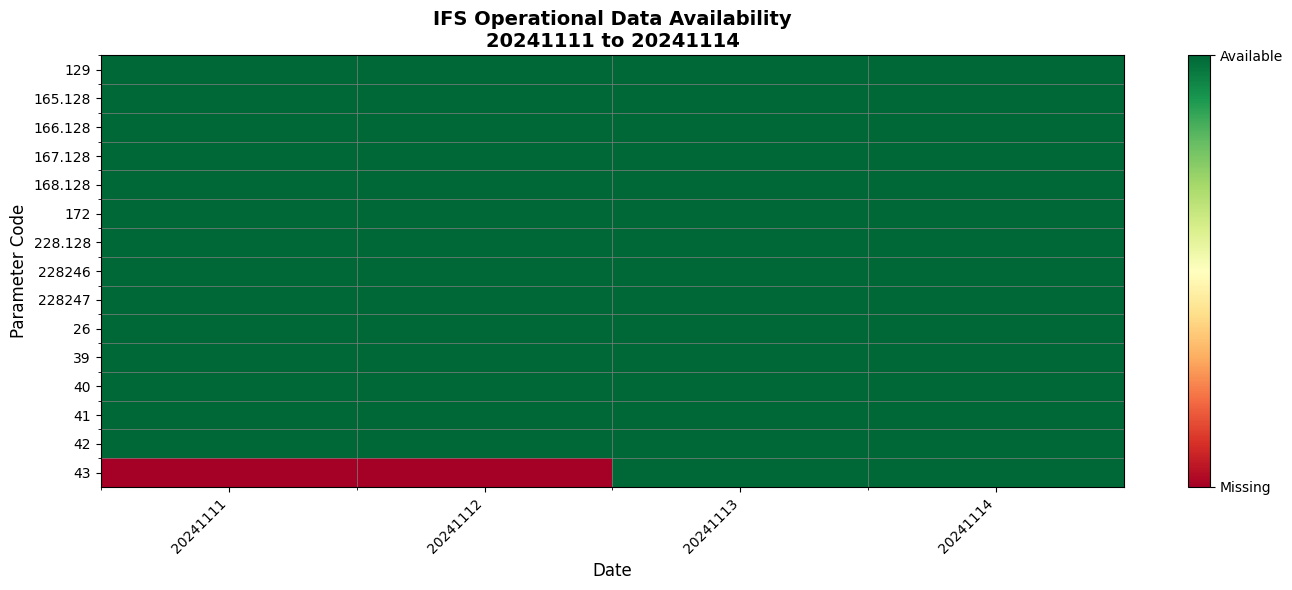


Green = Available, Red = Missing


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Create a pivot table for visualization
pivot_data = df.pivot(index='parameter_code', columns='date', values='available')

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Create heatmap
im = ax.imshow(pivot_data.astype(int), cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(pivot_data.columns)))
ax.set_yticks(np.arange(len(pivot_data.index)))
ax.set_xticklabels(pivot_data.columns, rotation=45, ha='right')
ax.set_yticklabels(pivot_data.index)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Missing', 'Available'])

# Add grid
ax.set_xticks(np.arange(len(pivot_data.columns)) - 0.5, minor=True)
ax.set_yticks(np.arange(len(pivot_data.index)) - 0.5, minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)

# Labels and title
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Parameter Code', fontsize=12)
ax.set_title(f'IFS Operational Data Availability\n{date_i} to {date_f}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nGreen = Available, Red = Missing")

---

## Notes and Tips

### Customizing Parameters
To check different variables, modify the `parameters` dictionary. You can use either:
- **Short names**: `2t`, `10u`, `10v`, `tp`, etc.
- **Parameter numbers**: `167`, `165`, `166`, `228`, etc.

Find the complete list in the [ECMWF Parameter Database](https://apps.ecmwf.int/codes/grib/param-db).

### Adjusting the Request
You can modify `build_ifs_check_request()` to change:
- **Grid resolution**: Change `grid` parameter (e.g., `"0.1/0.1"`)
- **Area**: Modify `area` bounding box
- **Forecast steps**: Change `step` parameter (e.g., `"0/to/48/by/3"` for 48h forecast at 3h intervals)
- **Level type**: Use `levtype: "pl"` for pressure levels, add `levelist` parameter

### Troubleshooting
- **Authentication errors**: Ensure your ECMWF API key is configured
- **No data available**: Check if the date is within the operational archive range
- **Timeout errors**: MARS may be slow; consider checking fewer dates/parameters at once

### Next Steps
Once availability is confirmed, use the download scripts:
- [DE374h_download.py](DE374h_download.py) for automated downloads
- Modify date range and run: `python DE374h_download.py --nwp ifs --run_where leonardo --date_i YYYYMMDD --date_f YYYYMMDD`

## Running via SLURM Job

To run this notebook as a batch job on Leonardo HPC:

### Method 1: Using the provided job script

```bash
# Submit with default dates (defined in the parameters cell)
sbatch Scripts/mars_check.job

# Submit with custom date range
sbatch Scripts/mars_check.job 20241201 20241210
```

### Method 2: Submit directly with sbatch

```bash
sbatch <<EOF
#!/bin/bash
#SBATCH --job-name=mars_check
#SBATCH --time=2:00:00
#SBATCH --ntasks=1
#SBATCH --mem=8G

cd \$HOME/DE374_lot2/
uv run papermill Scripts/mars_check.ipynb Scripts/mars_check_output.ipynb -p date_i 20241201 -p date_f 20241210
EOF
```

### Method 3: Convert to Python script

```bash
# Convert notebook to Python script
jupyter nbconvert --to script Scripts/mars_check.ipynb

# Then run the script via SLURM
sbatch <<EOF
#!/bin/bash
#SBATCH --job-name=mars_check
#SBATCH --time=2:00:00

cd \$HOME/DE374_lot2/
uv run python Scripts/mars_check.py
EOF
```

### Installing papermill (if needed)

```bash
uv pip install papermill
```

### Monitor job progress

```bash
# Check job status
squeue -u $USER

# View live output
tail -f /leonardo_scratch/large/userexternal/lmonaco0/DE374_lot2/zarr_deliv/log/mars_check_log_<jobid>.out
```